In [28]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms
from tensorflow import keras

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True,color=None):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    if color is None: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    else: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc),color=color)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL",color="grey",linestyle="--")
    plt.legend()
    return auc

def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

In [29]:
resolution = 60
window = 1.0
align = True

In [3]:
#covid_plasma
datadir = "D:/PeakDetective/data/covid_plasma/"
ms1ppm = 25.5
peakWidth = (13.8,114.6)
s2n = 13.6
noise = 1
mzDiff = 0.0144
prefilter = 5
cutoff = 0.9 #default cutoff from last run

In [28]:
# #ST000081
# datadir = "D:/PeakDetective/data/ST000081/"
# ms1ppm = 11.5
# peakWidth = (8.5,31.3)
# s2n = 6.81
# noise = 1
# mzDiff = 0.0144
# prefilter = 5.4
# cutoff = 0.6 #default cutoff from last run

In [30]:
#ST001882_GT_RP_Positive
datadir = "D:/PeakDetective/data/ST001882_GT_RP_Positive/"
ms1ppm = 11.5
peakWidth = (8.576,30)
s2n = 9.1
noise = 12970
mzDiff = 0.0144
prefilter = 1
cutoff = 0.5 #default cutoff from last run

In [31]:
det = detection_helper.PeakList()
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
peakList = pd.DataFrame(det.peakList)
peakList

,mz,rt,rt_start,rt_end,QC_01.mzML,QC_02.mzML,QC_03.mzML,QC_04.mzML,QC_05.mzML,QC_06.mzML,QC_07.mzML
FT00001,150.112310,0.747457,0.747450,0.756801,1.974936e+06,1.858493e+06,1.798871e+06,1.757297e+06,1.773365e+06,1.768485e+06,2.304243e+06
FT00002,150.026482,1.749602,1.747698,1.750253,2.826669e+07,2.815197e+07,2.841696e+07,2.881003e+07,3.145220e+07,3.074870e+07,3.318160e+07
FT00003,150.026490,2.845811,2.845758,2.855271,8.213799e+06,9.725321e+06,9.307397e+06,7.713435e+06,8.139520e+06,7.220048e+06,8.205855e+06
FT00004,150.062904,1.255499,1.255089,1.266733,3.205281e+05,3.206047e+05,2.857381e+05,3.124773e+05,3.306725e+05,3.484202e+05,3.416744e+05
FT00005,150.091273,0.845748,0.831618,0.859937,2.072345e+05,1.836083e+05,2.224421e+05,1.704847e+05,2.148285e+05,1.860289e+05,2.334494e+05
...,...,...,...,...,...,...,...,...,...,...,...
FT32177,1974.536430,8.815316,8.815316,8.815316,1.895676e+04,0.000000e+00,1.190416e+05,1.293768e+04,7.919847e+04,0.000000e+00,2.039624e+05
FT32178,1979.207415,6.249797,6.239919,6.258969,7.459506e+04,1.379095e+05,1.272461e+05,1.030717e+05,1.344736e+05,1.053646e+05,7.916662e+04
FT32179,1980.210251,6.249635,6.240197,6.258969,1.857563e+05,1.975252e+05,2.361436e+05,2.210434e+05,2.238891e+05,2.395129e+05,2.108537e+05
FT32180,1981.211674,6.249549,6.240390,6.249923,1.741973e+05,1.996532e+05,1.700717e+05,1.492381e+05,2.215041e+05,1.772771e+05,2.104139e+05


In [32]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['QC_01.mzML', 'QC_02.mzML', 'QC_03.mzML', 'QC_04.mzML', 'QC_05.mzML', 'QC_06.mzML', 'QC_07.mzML']


In [33]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

In [34]:
NeatMS_output_df= pd.read_csv(datadir + "NeatMS_output_df.csv",index_col=0)
NeatMS_output_df

,feature ID,sample,m/z,retention time,height,area,label
0,1834,QC_01,150.112310,0.747457,1.974936e+06,1.974936e+06,High_quality
1,1834,QC_02,150.112310,0.747457,1.858493e+06,1.858493e+06,Noise
2,1834,QC_03,150.112310,0.747457,1.798871e+06,1.798871e+06,High_quality
3,1834,QC_04,150.112310,0.747457,1.757297e+06,1.757297e+06,High_quality
4,1834,QC_05,150.112310,0.747457,1.773365e+06,1.773365e+06,High_quality
...,...,...,...,...,...,...,...
222235,34014,QC_03,1982.212953,6.249580,1.171374e+05,1.171374e+05,High_quality
222236,34014,QC_04,1982.212953,6.249580,1.096281e+05,1.096281e+05,High_quality
222237,34014,QC_05,1982.212953,6.249580,7.411829e+04,7.411829e+04,High_quality
222238,34014,QC_06,1982.212953,6.249580,1.437213e+05,1.437213e+05,High_quality


In [35]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir + "model_selection_data.pkl","rb"))

In [36]:
[peaks_test,X_val,y_val,X_test,y_test,X_labeled,y_labeled] = pkl.load(open(datadir+"eval_data.pkl","rb"))

In [37]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

,feature ID,sample,m/z,retention time,height,area,label
0,1834,QC_01,150.112310,0.747457,1.974936e+06,1.974936e+06,High_quality
7,1835,QC_01,150.026482,1.749602,2.826669e+07,2.826669e+07,Noise
14,1836,QC_01,150.026490,2.845811,8.213799e+06,8.213799e+06,Noise
21,1837,QC_01,150.062904,1.255499,3.205281e+05,3.205281e+05,Noise
28,1838,QC_01,150.091273,0.845748,2.072345e+05,2.072345e+05,Noise
...,...,...,...,...,...,...,...
222205,34010,QC_01,1974.536430,8.815316,1.895676e+04,1.895676e+04,High_quality
222212,34011,QC_01,1979.207415,6.249797,7.459506e+04,7.459506e+04,High_quality
222219,34012,QC_01,1980.210251,6.249635,1.857563e+05,1.857563e+05,High_quality
222226,34013,QC_01,1981.211674,6.249549,1.741973e+05,1.741973e+05,High_quality


In [38]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

84


In [39]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

,feature ID,sample,m/z,retention time,height,area,label,classification
20674,4888,QC_01,348.202281,2.306607,5.162621e+05,5.162621e+05,High_quality,1.0
31160,6406,QC_01,415.236194,2.514900,9.670136e+05,9.670136e+05,Noise,0.0
38526,7473,QC_01,464.130636,2.099991,4.530466e+05,4.530466e+05,High_quality,1.0
193209,29836,QC_01,1162.821425,6.886276,3.420084e+05,3.420084e+05,High_quality,1.0
56036,10019,QC_01,561.028082,1.580255,3.518102e+05,3.518102e+05,High_quality,1.0
...,...,...,...,...,...,...,...,...
168266,26248,QC_01,976.867846,8.326226,1.275476e+06,1.275476e+06,Noise,0.0
131175,20887,QC_01,846.201207,8.148647,1.288281e+05,1.288281e+05,Noise,0.0
16536,4281,QC_01,317.226233,2.590780,2.576830e+05,2.576830e+05,High_quality,1.0
62019,10890,QC_01,587.701837,0.738146,4.094488e+05,4.094488e+05,High_quality,1.0


In [40]:
X_test = X_test[order]
y_test = y_test[order]

In [41]:
integ.load(datadir + "supervised/")

In [42]:
y_test_scores_supervised = integ.classifyMatrix(X_test)

3/3 [==============================] - 0s 0s/step


In [43]:
if __name__ == "__main__":
    mzs = rd.choices(list(peakList["mz"].values),k=int(100000/len(raw_data)))
    rts = rd.choices(list(peakList["rt"].values),k=int(100000/len(raw_data)))
    tmp = integ.makeDataMatrix(raw_data,mzs,rts)
    pca = PCA(5)
    tmp_norm = PeakDetective.normalizeMatrix(tmp)
    pca.fit(tmp_norm)

    tics = np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X_labeled]))
    ticVal = np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X_val]))

    X_labeled_load = pca.transform(PeakDetective.normalizeMatrix(X_labeled))
    X_val_load = pca.transform(PeakDetective.normalizeMatrix(X_val))

    restarts = 1
    min_epochs = 200
    max_epochs = 1000
    batch_size = 4

    bestLoss = np.inf
    bestWeights = -1
    bestValErr = -1
    bestBestEpoch = -1
    trainErr = -1
    trainLoss = -1

    #iterate over random restarts
    for x in range(restarts):

        #make callback object
        cb = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=3,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )

        history = keras.callbacks.History()

        # initialize classifier
        classifer = PeakDetective.ClassifierLatent(X_labeled_load.shape[1])

        #train to minimum epochs
        if min_epochs > 0:
            classifer.fit([X_labeled_load,tics],y_labeled,epochs=int(min_epochs),batch_size=batch_size,verbose=0,
                          validation_data=([X_val_load, ticVal], y_val))

        #train until maximum epochs with early stopping
        classifer.fit([X_labeled_load, tics], y_labeled, epochs=int(max_epochs-min_epochs),
                      batch_size=batch_size, verbose=0, callbacks=[cb, history],
                      validation_data=([X_val_load, ticVal], y_val))

        #get performance
        valLoss = history.history["val_loss"][cb.best_epoch]
        valErr = history.history["val_mean_absolute_error"][cb.best_epoch]
        bestEpoch = cb.best_epoch

        #update best performers
        if valLoss < bestLoss:
            bestLoss = valLoss
            bestWeights = classifer.get_weights()
            bestValErr = valErr
            bestBestEpoch = bestEpoch
            trainLoss = history.history["loss"][cb.best_epoch]
            trainErr = history.history["mean_absolute_error"][cb.best_epoch]

    #print performance
    print("loss:",trainLoss,"mean_absolute_error:",trainErr,"val loss:", bestLoss, "val_mean_absolute_error:",bestValErr, "numEpochs:", min_epochs + bestBestEpoch)

    #set best weights
    integ.classifier.set_weights(bestWeights)

forming matrix |██████████████████████████████████████████████████| 100.0% 
loss: 0.48882004618644714 mean_absolute_error: 0.2769639790058136 val loss: 0.5027862787246704 val_mean_absolute_error: 0.29393675923347473 numEpochs: 916


In [44]:
y_test_scores_pca = integ.classifier.predict([pca.transform(PeakDetective.normalizeMatrix(X_test)),np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X_test]))])

3/3 [==============================] - 0s 0s/step


In [45]:
np.mean(y_test_scores_pca[:,1])

0.8854356

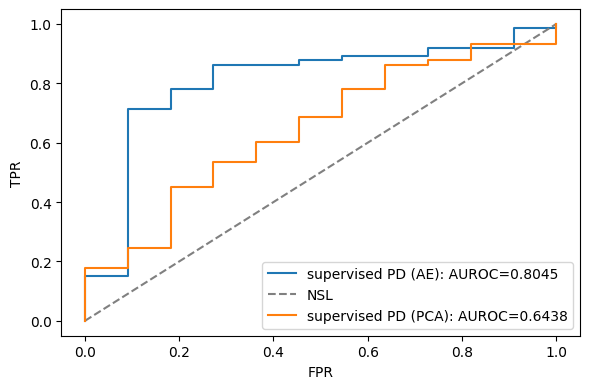

In [46]:
makeROCPlot(y_test_scores_supervised[:,1],y_test[:,1],noSkill=True,label="supervised PD (AE)")
makeROCPlot(y_test_scores_pca[:,1],y_test[:,1],noSkill=False,label="supervised PD (PCA)")
plt.tight_layout()
plt.savefig(datadir+"ROC_oca.png",dpi=300)

In [47]:
X_norm = PeakDetective.normalizeMatrix(X)

In [48]:
X_smoothed_pca = pca.inverse_transform(pca.transform(X_norm))
X_smoothed_AE = integ.smoother.predict(X_norm)

7040/7040 [==============================] - 50s 7ms/step


In [49]:
errors = []
for i,x in enumerate(X_norm):
    errors.append([met.r2_score(x,X_smoothed_pca[i]),met.r2_score(x,X_smoothed_AE[i])])
errors[0]

[0.13572907189543604, 0.9116765686983012]

23.729861723727346 37.111025255532034


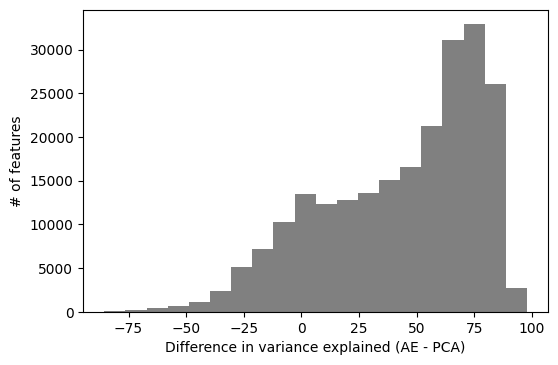

In [50]:
plt.hist([100*(errors[x][1] - errors[x][0]) for x in range(len(errors))],bins=20,color="grey")
plt.xlabel("Difference in variance explained (AE - PCA)")
plt.ylabel("# of features")
print(np.mean([100*(errors[x][1] - errors[x][0]) for x in range(len(order))]),np.std([100*(errors[x][1] - errors[x][0]) for x in range(len(order))]))
plt.savefig(datadir+"hist_var_explained.png",dpi=300)

In [51]:
tmpOrder = [x for x in range(len(errors)) if errors[x][1] > 0.9]
tmpOrder.sort(key=lambda x: errors[x][1] - errors[x][0],reverse=True)

In [52]:
len(tmpOrder)

51202

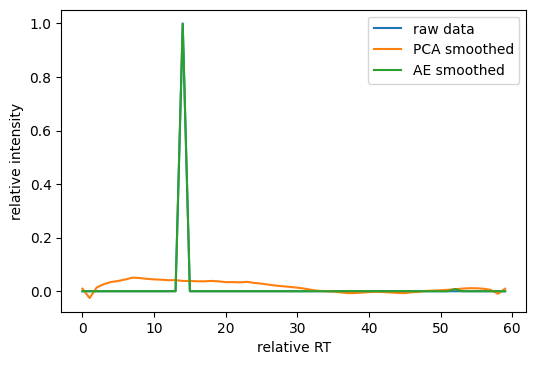

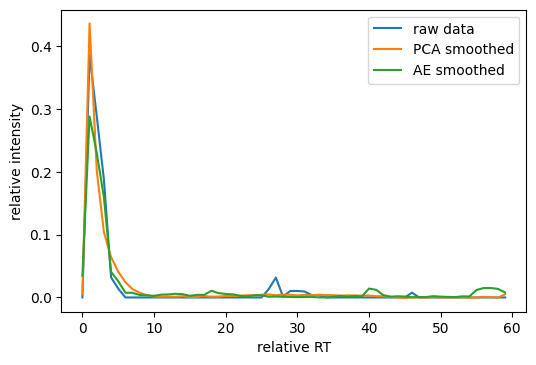

In [53]:
inds = [tmpOrder[0],tmpOrder[-100]]
labels = ["best","worst"]
for ind in inds:
    plt.figure()
    plt.plot(X_norm[ind],label="raw data")
    plt.plot(X_smoothed_pca[ind],label="PCA smoothed")
    plt.plot(X_smoothed_AE[ind],label="AE smoothed")
    plt.xlabel("relative RT")
    plt.ylabel("relative intensity")
    plt.legend()

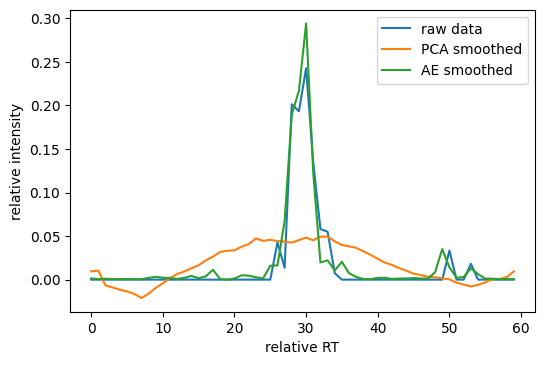

In [57]:
ind = rd.choice(list(range(len(X_norm))))
plt.figure()
plt.plot(X_norm[ind],label="raw data")
plt.plot(X_smoothed_pca[ind],label="PCA smoothed")
plt.plot(X_smoothed_AE[ind],label="AE smoothed")
plt.xlabel("relative RT")
plt.ylabel("relative intensity")
plt.legend()
plt.savefig(datadir + "example_smoothing.png",dpi=300)
